# THUCNews

最近试图把机器学习的东西捡起来。于是随便找了个数据集练习了一下。

* 数据集： https://www.kaggle.com/datasets/trumanjagan/thucnews
  * 如果遇到乱码问题，记得带上编码参数：`unzip -O utf-8 -q THUCNews.zip`
* 练习赛：中文新闻文本标题分类 https://aistudio.baidu.com/aistudio/competition/detail/10/0/introduction

In [7]:
from experiment import (
    ExperimentParameters,
    load_data,
    setup_datasets,
    NewsTitleClassifierBaseline,
    NewsTitleClassifierContrastive,
    Tester,
    train
)

In [8]:
PARAMS = ExperimentParameters()
load_data(PARAMS)
setup_datasets(PARAMS)
PARAMS.MODEL = NewsTitleClassifierBaseline(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    PARAMS.tag_list,
).to(PARAMS.DEVICE)
PARAMS.tester = Tester(PARAMS, PARAMS.quick_test_dataset)

loading data...
dict_keys(['财经', '股票', '科技', '社会', '游戏', '星座', '时政', '时尚', '教育', '房产', '彩票', '家居', '娱乐', '体育'])
splitting datasets...


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
PARAMS.quick_test_dataset[:10]

[('娱乐', '陈楚生向法院提出解约 与天娱彻底拉爆(附图)\n'),
 ('娱乐', '何洁否认整容称被曲解：只在妈妈那里整过\n'),
 ('教育', '高考提示：体验考场该做什么\n'),
 ('科技', '苹果：与联通iPhone合约非排他性协议\n'),
 ('科技', '《征途2》仍处测试阶段 最高在线人数破30万\n'),
 ('科技', '网民在家上网比例已超80% 上网时间继续增加\n'),
 ('教育', '必看：如何让小升初英语面试胸有成竹\n'),
 ('体育', '连败让火箭训练场气氛沉静 21比3活力小子蔫头耷脑\n'),
 ('科技', '超薄靓丽时尚机 卡西欧Z16杭城惊报690\n'),
 ('股票', '站上半年线 有望挑战60日线\n')]

## 数据挖掘

首先我们数据挖掘一下，看看数据集标签的比例。

In [10]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

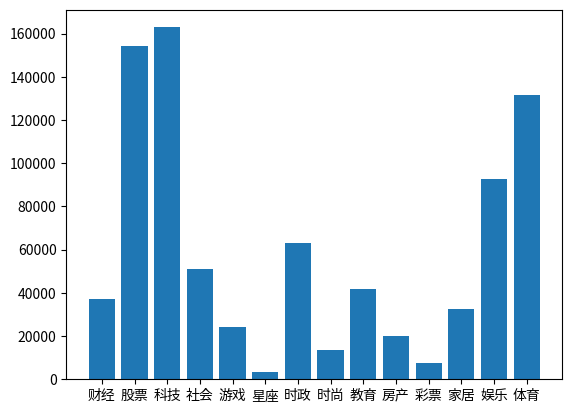

In [4]:
ys = [y for y, x in PARAMS.category_and_titles]
catag_count = [ys.count(tag) for tag in PARAMS.tag_list]

fig, ax = plt.subplots()
ax.bar(PARAMS.tag_list, catag_count)

plt.show()

## LoRA

In [167]:
import torch
import math

import torchvision.transforms as transforms

class SimLora(torch.nn.Module):
    def __init__(
            self,
            in_features: int, 
            out_features: int, 
            r: int = 0,
            **kwargs) -> None:
        super().__init__(**kwargs)
        self.lora_A = torch.nn.Parameter(torch.zeros((r, in_features)))
        self.lora_B = torch.nn.Parameter(torch.zeros((out_features, r)))
        torch.nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        torch.nn.init.kaiming_uniform_(self.lora_B, a=math.sqrt(5))
        #torch.nn.init.zeros_(self.lora_B)

    def forward(self, x: torch.Tensor):
        # @ is torch.matmul
        return x @ self.lora_A.T @ self.lora_B.T
    
    def dummy(self):
        return (self.lora_A.T @ self.lora_B.T).T


def print_weight(tensor1, tensor2, tensor3, tensor4):
    to_image = transforms.ToPILImage()
    img1 = to_image(tensor1)
    img2 = to_image(tensor2)
    img3 = to_image(tensor3)
    img4 = to_image(tensor4)
    f, add = plt.subplots(1, 4)
    add[0].imshow(img1)
    add[1].imshow(img2)
    add[2].imshow(img3)
    add[3].imshow(img4)
    plt.show()


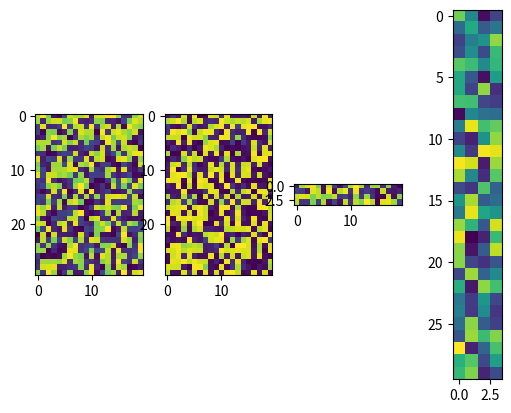

tensor(0.1352, grad_fn=<MseLossBackward0>)
tensor(0.0211, grad_fn=<MseLossBackward0>)


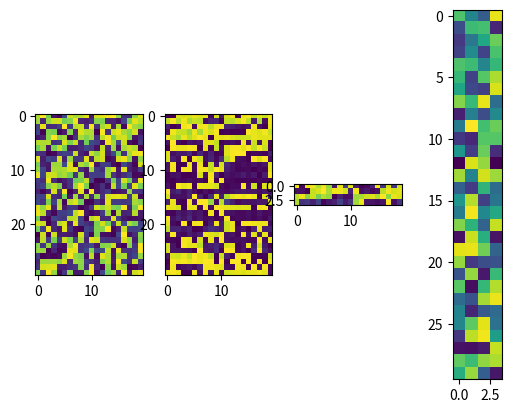

In [170]:
linear_layer = torch.nn.Linear(20, 30, bias=False)
lora_layer = SimLora(linear_layer.in_features, linear_layer.out_features, r=4)
print_weight(linear_layer.weight, lora_layer.dummy(), lora_layer.lora_A, lora_layer.lora_B)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(
    lora_layer.parameters(), lr=0.05
)

steps = 2000
batch_size = 100
for i in range(steps):
    optimizer.zero_grad()

    input = torch.rand(batch_size, linear_layer.in_features)
    y_g = linear_layer(input)
    y_p = lora_layer(input)
    loss = loss_fn(y_p, y_g)
    loss.backward()
    if i == 0 or i == steps - 1:
        print(loss)
    optimizer.step()
print_weight(linear_layer.weight, lora_layer.dummy(), lora_layer.lora_A, lora_layer.lora_B)

In [23]:
import re
import torch
import transformers
from transformers.models.bert.modeling_bert import (BertSelfAttention, BertSelfOutput, BertIntermediate, BertOutput, BertPooler)
import loralib

PARAMS.MODEL = NewsTitleClassifierBaseline(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    PARAMS.tag_list,
)

patterns = [
    "attention.self",
    "attention.output.dense"
]

TOTAL_LINEAR_WEIGHT_PARAMS_COUNT = 0
TOTAL_LORA_WEIGHT_PARAMS_COUNT = 0

#LORA_RANK = 0
#LORA_RANK = 1 # ratio: 0.0020
#LORA_RANK = 4 # ratio: 0.0078
LORA_RANK = 16 # ratio: 0.0313


def lora_linear(original: torch.nn.modules.linear.Linear):
    global TOTAL_LINEAR_WEIGHT_PARAMS_COUNT
    global TOTAL_LORA_WEIGHT_PARAMS_COUNT
    rank = LORA_RANK 

    lora = loralib.Linear(original.in_features, original.out_features, r=rank)
    lora.weight = torch.nn.Parameter(torch.clone(original.weight))
    if original.bias is not None:
        lora.bias = torch.nn.Parameter(torch.clone(original.bias).detach())

    if rank > 0:
        TOTAL_LINEAR_WEIGHT_PARAMS_COUNT += original.weight.numel()
        TOTAL_LORA_WEIGHT_PARAMS_COUNT += lora.lora_A.numel() + lora.lora_B.numel()

    return lora

def handle_BertSelfAttention(module):
    if isinstance(module, BertSelfAttention):
        print("patching", type(module))
        module.query = lora_linear(module.query)
        module.key = lora_linear(module.key)
        module.value = lora_linear(module.value)

def handle_has_dense(module):
    has_dense = [BertSelfOutput, BertIntermediate, BertOutput, BertPooler]
    if type(module) in has_dense:
        print("patching", type(module))
        module.dense = lora_linear(module.dense)

# Patch!
for key, module in PARAMS.MODEL._model.named_modules():
    handle_BertSelfAttention(module)
    handle_has_dense(module)

if LORA_RANK > 0:
    print("ratio:", f"{TOTAL_LORA_WEIGHT_PARAMS_COUNT / TOTAL_LINEAR_WEIGHT_PARAMS_COUNT:.4f}")

loralib.mark_only_lora_as_trainable(PARAMS.MODEL._model)

PARAMS.MODEL = PARAMS.MODEL.to(PARAMS.DEVICE)
train_accuracy_record, test_accuracy_record = train(PARAMS)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


patching <class 'transformers.models.bert.modeling_bert.BertSelfAttention'>
patching <class 'transformers.models.bert.modeling_bert.BertSelfOutput'>
patching <class 'transformers.models.bert.modeling_bert.BertIntermediate'>
patching <class 'transformers.models.bert.modeling_bert.BertOutput'>
patching <class 'transformers.models.bert.modeling_bert.BertSelfAttention'>
patching <class 'transformers.models.bert.modeling_bert.BertSelfOutput'>
patching <class 'transformers.models.bert.modeling_bert.BertIntermediate'>
patching <class 'transformers.models.bert.modeling_bert.BertOutput'>
patching <class 'transformers.models.bert.modeling_bert.BertSelfAttention'>
patching <class 'transformers.models.bert.modeling_bert.BertSelfOutput'>
patching <class 'transformers.models.bert.modeling_bert.BertIntermediate'>
patching <class 'transformers.models.bert.modeling_bert.BertOutput'>
patching <class 'transformers.models.bert.modeling_bert.BertSelfAttention'>
patching <class 'transformers.models.bert.mod

  3%|▎         | 102/3345 [00:16<14:47,  3.65it/s]

training accuracy: 0.2345
test accuracy: 0.2899


  6%|▌         | 202/3345 [00:32<13:57,  3.75it/s]

training accuracy: 0.3097
test accuracy: 0.3192
Adjusting learning rate of group 0 to 5.7000e-02.


  9%|▉         | 302/3345 [00:49<13:32,  3.75it/s]

training accuracy: 0.3688
test accuracy: 0.3993


 12%|█▏        | 402/3345 [01:05<13:07,  3.74it/s]

training accuracy: 0.4321
test accuracy: 0.4399
Adjusting learning rate of group 0 to 5.4150e-02.


 15%|█▌        | 502/3345 [01:22<12:36,  3.76it/s]

training accuracy: 0.4585
test accuracy: 0.4668


 18%|█▊        | 602/3345 [01:38<12:30,  3.66it/s]

training accuracy: 0.4703
test accuracy: 0.4650
Adjusting learning rate of group 0 to 5.1442e-02.


 21%|██        | 702/3345 [01:55<12:07,  3.63it/s]

training accuracy: 0.4732
test accuracy: 0.4740


 24%|██▍       | 802/3345 [02:11<11:59,  3.54it/s]

training accuracy: 0.4797
test accuracy: 0.4806
Adjusting learning rate of group 0 to 4.8870e-02.


 27%|██▋       | 902/3345 [02:28<10:53,  3.74it/s]

training accuracy: 0.4803
test accuracy: 0.4931


 30%|██▉       | 1002/3345 [02:44<10:33,  3.70it/s]

training accuracy: 0.4958
test accuracy: 0.4997
Adjusting learning rate of group 0 to 4.6427e-02.


 33%|███▎      | 1102/3345 [03:01<10:01,  3.73it/s]

training accuracy: 0.5093
test accuracy: 0.5146


 36%|███▌      | 1202/3345 [03:17<09:41,  3.69it/s]

training accuracy: 0.5155
test accuracy: 0.5284
Adjusting learning rate of group 0 to 4.4106e-02.


 39%|███▉      | 1302/3345 [03:34<09:19,  3.65it/s]

training accuracy: 0.5370
test accuracy: 0.5350


 42%|████▏     | 1402/3345 [03:50<08:50,  3.66it/s]

training accuracy: 0.5379
test accuracy: 0.5392
Adjusting learning rate of group 0 to 4.1900e-02.


 45%|████▍     | 1502/3345 [04:07<08:05,  3.79it/s]

training accuracy: 0.5472
test accuracy: 0.5517


 48%|████▊     | 1602/3345 [04:23<07:40,  3.78it/s]

training accuracy: 0.5624
test accuracy: 0.5637
Adjusting learning rate of group 0 to 3.9805e-02.


 51%|█████     | 1702/3345 [04:39<07:18,  3.75it/s]

training accuracy: 0.5708
test accuracy: 0.5720


 54%|█████▍    | 1802/3345 [04:55<06:49,  3.77it/s]

training accuracy: 0.5782
test accuracy: 0.5864
Adjusting learning rate of group 0 to 3.7815e-02.


 57%|█████▋    | 1902/3345 [05:11<06:25,  3.74it/s]

training accuracy: 0.5911
test accuracy: 0.5941


 60%|█████▉    | 2002/3345 [05:28<05:56,  3.77it/s]

training accuracy: 0.5994
test accuracy: 0.6043
Adjusting learning rate of group 0 to 3.5924e-02.


 63%|██████▎   | 2102/3345 [05:44<05:29,  3.77it/s]

training accuracy: 0.6180
test accuracy: 0.6133


 66%|██████▌   | 2202/3345 [06:00<05:06,  3.73it/s]

training accuracy: 0.6202
test accuracy: 0.6234
Adjusting learning rate of group 0 to 3.4128e-02.


 69%|██████▉   | 2302/3345 [06:16<04:38,  3.75it/s]

training accuracy: 0.6383
test accuracy: 0.6354


 72%|███████▏  | 2402/3345 [06:32<04:09,  3.77it/s]

training accuracy: 0.6496
test accuracy: 0.6491
Adjusting learning rate of group 0 to 3.2422e-02.


 75%|███████▍  | 2502/3345 [06:48<03:45,  3.73it/s]

training accuracy: 0.6637
test accuracy: 0.6659


 78%|███████▊  | 2602/3345 [07:05<03:19,  3.72it/s]

training accuracy: 0.6734
test accuracy: 0.6754
Adjusting learning rate of group 0 to 3.0801e-02.


 81%|████████  | 2702/3345 [07:21<02:49,  3.79it/s]

training accuracy: 0.6843
test accuracy: 0.6880


 84%|████████▍ | 2802/3345 [07:37<02:24,  3.76it/s]

training accuracy: 0.6926
test accuracy: 0.7023
Adjusting learning rate of group 0 to 2.9260e-02.


 87%|████████▋ | 2902/3345 [07:53<01:59,  3.70it/s]

training accuracy: 0.7079
test accuracy: 0.7161


 90%|████████▉ | 3002/3345 [08:10<01:31,  3.74it/s]

training accuracy: 0.7062
test accuracy: 0.7233
Adjusting learning rate of group 0 to 2.7797e-02.


 93%|█████████▎| 3102/3345 [08:26<01:06,  3.67it/s]

training accuracy: 0.7178
test accuracy: 0.7286


 96%|█████████▌| 3202/3345 [08:42<00:38,  3.76it/s]

training accuracy: 0.7264
test accuracy: 0.7316
Adjusting learning rate of group 0 to 2.6408e-02.


 99%|█████████▊| 3302/3345 [08:59<00:11,  3.72it/s]

training accuracy: 0.7334
test accuracy: 0.7388


100%|██████████| 3345/3345 [09:05<00:00,  6.13it/s]


overall accuracy: 0.7406
tag,	recall,	precision
'财经',	0.0000,	0.0000
'股票',	0.9159,	0.7040
'科技',	0.8926,	0.5951
'社会',	0.7451,	0.9048
'游戏',	0.0000,	0.0000
'星座',	0.0000,	0.0000
'时政',	0.7143,	0.9184
'时尚',	0.0000,	0.0000
'教育',	0.8095,	1.0000
'房产',	0.0000,	0.0000
'彩票',	0.0000,	0.0000
'家居',	0.0000,	0.0000
'娱乐',	0.9462,	0.7097
'体育',	0.9696,	0.8979


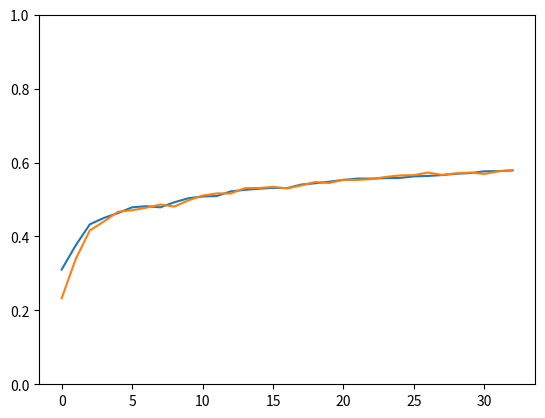

In [18]:
# R = 0
batch_num = [i for i in range(len(test_accuracy_record))]
plt.plot(batch_num, test_accuracy_record, train_accuracy_record)
plt.ylim([0,1])
plt.show()

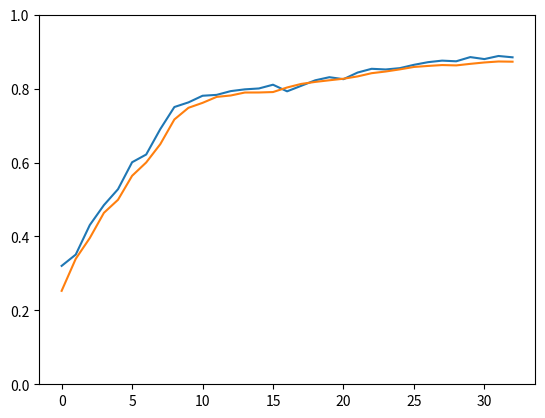

In [20]:
# R = 1
# overall accuracy: ~0.89
batch_num = [i for i in range(len(test_accuracy_record))]
plt.plot(batch_num, test_accuracy_record, train_accuracy_record)
plt.ylim([0,1])
plt.show()

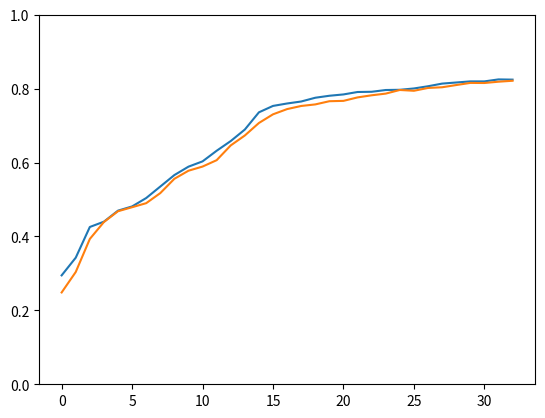

In [22]:
# R = 4
# overall accuracy: 0.8261
batch_num = [i for i in range(len(test_accuracy_record))]
plt.plot(batch_num, test_accuracy_record, train_accuracy_record)
plt.ylim([0,1])
plt.show()

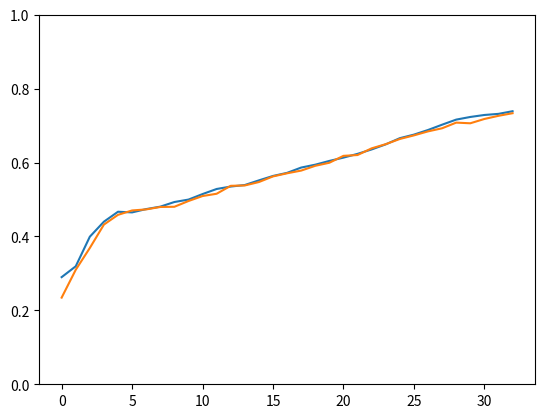

In [24]:
# R = 16
# overall accuracy: 0.7406
# 9m22s
batch_num = [i for i in range(len(test_accuracy_record))]
plt.plot(batch_num, test_accuracy_record, train_accuracy_record)
plt.ylim([0,1])
plt.show()

## 普通模型

In [25]:
PARAMS.MODEL = NewsTitleClassifierBaseline(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    PARAMS.tag_list,
).to(PARAMS.DEVICE)

train_accuracy_record, test_accuracy_record = train(PARAMS)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Adjusting learning rate of group 0 to 6.0000e-02.
epoch: 0


  3%|▎         | 102/3345 [00:14<12:52,  4.20it/s]

training accuracy: 0.5211
test accuracy: 0.5702


  6%|▌         | 202/3345 [00:29<12:08,  4.31it/s]

training accuracy: 0.7000
test accuracy: 0.7567
Adjusting learning rate of group 0 to 5.7000e-02.


  9%|▉         | 302/3345 [00:44<12:05,  4.20it/s]

training accuracy: 0.7759
test accuracy: 0.8045


 12%|█▏        | 402/3345 [00:58<11:32,  4.25it/s]

training accuracy: 0.7907
test accuracy: 0.7962
Adjusting learning rate of group 0 to 5.4150e-02.


 15%|█▌        | 502/3345 [01:13<10:49,  4.37it/s]

training accuracy: 0.8062
test accuracy: 0.8141


 18%|█▊        | 602/3345 [01:27<10:48,  4.23it/s]

training accuracy: 0.8203
test accuracy: 0.8332
Adjusting learning rate of group 0 to 5.1442e-02.


 21%|██        | 702/3345 [01:42<10:31,  4.19it/s]

training accuracy: 0.8290
test accuracy: 0.8434


 24%|██▍       | 802/3345 [01:57<10:41,  3.97it/s]

training accuracy: 0.8509
test accuracy: 0.8775
Adjusting learning rate of group 0 to 4.8870e-02.


 27%|██▋       | 902/3345 [02:12<09:53,  4.12it/s]

training accuracy: 0.8571
test accuracy: 0.8709


 30%|██▉       | 1002/3345 [02:27<09:26,  4.14it/s]

training accuracy: 0.8777
test accuracy: 0.8649
Adjusting learning rate of group 0 to 4.6427e-02.


 33%|███▎      | 1102/3345 [02:42<08:52,  4.21it/s]

training accuracy: 0.8871
test accuracy: 0.9002


 36%|███▌      | 1202/3345 [02:57<08:30,  4.20it/s]

training accuracy: 0.8955
test accuracy: 0.8966
Adjusting learning rate of group 0 to 4.4106e-02.


 39%|███▉      | 1302/3345 [03:11<08:30,  4.00it/s]

training accuracy: 0.9010
test accuracy: 0.9085


 42%|████▏     | 1402/3345 [03:26<07:37,  4.24it/s]

training accuracy: 0.9073
test accuracy: 0.9091
Adjusting learning rate of group 0 to 4.1900e-02.


 45%|████▍     | 1502/3345 [03:41<07:07,  4.31it/s]

training accuracy: 0.9032
test accuracy: 0.9175


 48%|████▊     | 1602/3345 [03:55<06:47,  4.28it/s]

training accuracy: 0.9120
test accuracy: 0.9217
Adjusting learning rate of group 0 to 3.9805e-02.


 51%|█████     | 1702/3345 [04:10<06:29,  4.22it/s]

training accuracy: 0.9172
test accuracy: 0.9283


 54%|█████▍    | 1802/3345 [04:25<06:03,  4.24it/s]

training accuracy: 0.9174
test accuracy: 0.9241
Adjusting learning rate of group 0 to 3.7815e-02.


 57%|█████▋    | 1902/3345 [04:39<05:41,  4.22it/s]

training accuracy: 0.9180
test accuracy: 0.9241


 60%|█████▉    | 2002/3345 [04:54<05:11,  4.31it/s]

training accuracy: 0.9166
test accuracy: 0.9319
Adjusting learning rate of group 0 to 3.5924e-02.


 63%|██████▎   | 2102/3345 [05:09<04:58,  4.17it/s]

training accuracy: 0.9197
test accuracy: 0.9247


 66%|██████▌   | 2202/3345 [05:24<04:25,  4.31it/s]

training accuracy: 0.9188
test accuracy: 0.9247
Adjusting learning rate of group 0 to 3.4128e-02.


 69%|██████▉   | 2302/3345 [05:39<04:02,  4.30it/s]

training accuracy: 0.9236
test accuracy: 0.9193


 72%|███████▏  | 2402/3345 [05:53<03:48,  4.13it/s]

training accuracy: 0.9215
test accuracy: 0.9277
Adjusting learning rate of group 0 to 3.2422e-02.


 75%|███████▍  | 2502/3345 [06:08<03:15,  4.30it/s]

training accuracy: 0.9247
test accuracy: 0.9277


 78%|███████▊  | 2602/3345 [06:23<02:53,  4.28it/s]

training accuracy: 0.9248
test accuracy: 0.9337
Adjusting learning rate of group 0 to 3.0801e-02.


 81%|████████  | 2702/3345 [06:37<02:31,  4.26it/s]

training accuracy: 0.9237
test accuracy: 0.9319


 84%|████████▍ | 2802/3345 [06:52<02:06,  4.29it/s]

training accuracy: 0.9221
test accuracy: 0.9313
Adjusting learning rate of group 0 to 2.9260e-02.


 87%|████████▋ | 2902/3345 [07:07<01:43,  4.27it/s]

training accuracy: 0.9247
test accuracy: 0.9319


 90%|████████▉ | 3002/3345 [07:22<01:21,  4.19it/s]

training accuracy: 0.9254
test accuracy: 0.9372
Adjusting learning rate of group 0 to 2.7797e-02.


 93%|█████████▎| 3102/3345 [07:37<00:57,  4.22it/s]

training accuracy: 0.9285
test accuracy: 0.9325


 96%|█████████▌| 3202/3345 [07:51<00:33,  4.27it/s]

training accuracy: 0.9316
test accuracy: 0.9414
Adjusting learning rate of group 0 to 2.6408e-02.


 99%|█████████▊| 3302/3345 [08:06<00:10,  4.06it/s]

training accuracy: 0.9293
test accuracy: 0.9438


100%|██████████| 3345/3345 [08:12<00:00,  6.79it/s]


overall accuracy: 0.9384
tag,	recall,	precision
'财经',	0.9054,	0.8272
'股票',	0.9385,	0.9603
'科技',	0.9479,	0.9567
'社会',	0.9216,	0.8704
'游戏',	0.8776,	0.9556
'星座',	0.0000,	0.0000
'时政',	0.9365,	0.9219
'时尚',	0.8148,	0.9565
'教育',	0.9881,	0.9651
'房产',	0.8000,	0.8889
'彩票',	0.4667,	1.0000
'家居',	0.9385,	0.9104
'娱乐',	0.9839,	0.9196
'体育',	0.9924,	0.9739


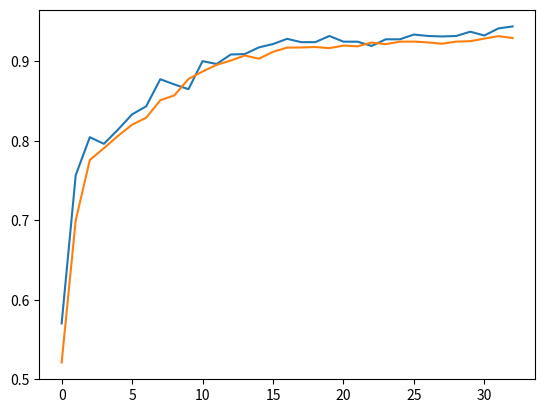

In [26]:
# overall accuracy: 0.9384
# 8m28s
batch_num = [i for i in range(len(test_accuracy_record))]
plt.plot(batch_num, test_accuracy_record, train_accuracy_record)
plt.show()

## 对比学习
试试CLIP https://github.com/openai/CLIP

In [ ]:
PARAMS.MODEL = NewsTitleClassifierContrastive(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    tag_list=PARAMS.tag_list,
    prompt_list=PARAMS.tag_list,
).to(PARAMS.DEVICE)

train_accuracy_record_contrastive, test_accuracy_record_contrastive = train(PARAMS)

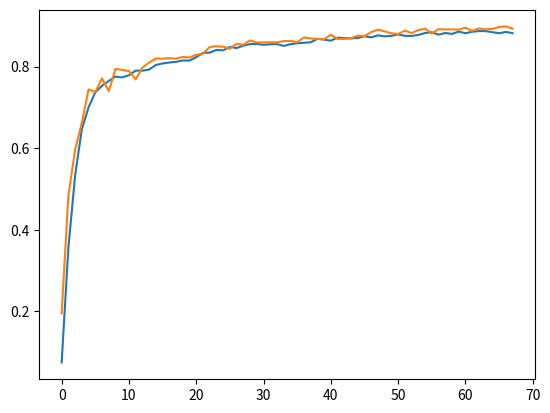

In [8]:
batch_num = [i for i in range(len(test_accuracy_record))]
plt.plot(batch_num, train_accuracy_record_contrastive, test_accuracy_record_contrastive)
plt.show()

### 用Prompt做对比学习

In [ ]:
prompts = [f"这是一篇{tag}新闻" for tag in PARAMS.tag_list]

PARAMS.MODEL = NewsTitleClassifierContrastive(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    tag_list=PARAMS.tag_list,
    prompt_list=prompts,
).to(PARAMS.DEVICE)

train_accuracy_record_contrastive_prompt, test_accuracy_record_contrastive_prompt = train(PARAMS)

### 去掉softmax

In [ ]:
PARAMS.MODEL = NewsTitleClassifierContrastive(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    tag_list=PARAMS.tag_list,
    prompt_list=PARAMS.tag_list,
    softmax=False
).to(PARAMS.DEVICE)

train_accuracy_record_contrastive_no_softmax, test_accuracy_record_contrastive_no_softmax = train(PARAMS)

### 对称loss

才看到论文里面有一个：

```python
loss_i = cross_entropy_loss(logits, labels, axis=0)
loss_t = cross_entropy_loss(logits, labels, axis=1)
loss = (loss_i + loss_t)/2
```

然后[代码](https://github.com/openai/CLIP/blob/main/clip/model.py)里面是这样的：

```python
# cosine similarity as logits
logit_scale = self.logit_scale.exp()
logits_per_image = logit_scale * image_features @ text_features.t()
logits_per_text = logits_per_image.t()

# shape = [global_batch_size, global_batch_size]
return logits_per_image, logits_per_text
```

In [ ]:
PARAMS.MODEL = NewsTitleClassifierContrastive(
    PARAMS.DEVICE,
    PARAMS.MODEL_NAME,
    PARAMS.MODEL_HIDDEN_SIZE,
    tag_list=PARAMS.tag_list,
    prompt_list=PARAMS.tag_list,
    softmax=True
).to(PARAMS.DEVICE)

records_symmetric_loss = train(PARAMS, symmetric_loss=True)

# 分析对比

In [9]:
import pickle
with open("./records.pickle", "rb") as file:
    records = pickle.load(file)

In [18]:
import pickle

with open("./records.pickle", "wb") as file:
    records.update({"contrastive_with_softmax_with_symmetric": records_symmetric_loss})
    pickle.dump(records, file)


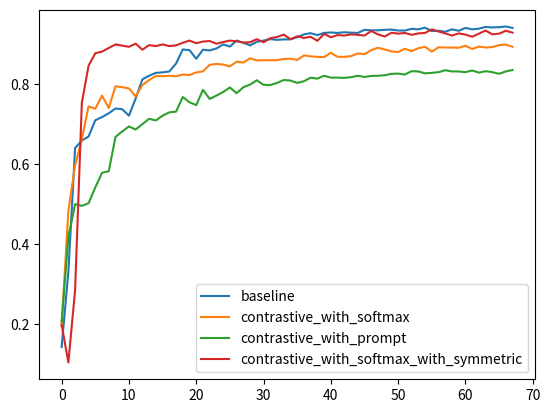

In [20]:
batch_num = [i for i in range(len(records_symmetric_loss[1]))]
plt.plot(batch_num, records["baseline"][1], label="baseline")
plt.plot(batch_num, records["contrastive_with_softmax"][1], label="contrastive_with_softmax")
plt.plot(batch_num, records["contrastive_with_prompt"][1], label="contrastive_with_prompt")
plt.plot(batch_num, records["contrastive_with_softmax_with_symmetric"][1], label="contrastive_with_softmax_with_symmetric")
plt.legend()
plt.show()